![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# *Final Project: Contextual Bandits - Data Exploration*

## Reinforcement Learning

#### Authors: **Timothy Cassel, Marvin Ernst, Oliver Tausendschön**

Date: July 2, 2025

Instructors: *Hamish Flynn and Vincent Adam*

In this notebook, we explore the **Open Bandit Dataset (OBD)** — a real-world logged bandit dataset from the ZOZOTOWN fashion e-commerce platform. The dataset contains interaction-level feedback under two A/B tested recommendation policies: uniform random and Thompson Sampling (BTS).

We focus on the **raw full dataset** under the **random policy**, and perform an in-depth analysis of:

- The distribution and coverage of actions (fashion items)
- The sparsity and structure of reward signals (clicks)
- The feature space of user context vectors
- Implications for offline bandit evaluation and contextual policy learning

This exploration lays the empirical foundation for building, validating, and benchmarking contextual bandit algorithms in the final project.

---

## Dataset Summary

- **Platform**:  
  ZOZOTOWN — Japan’s largest fashion e-commerce platform

- **Logged Policy**:  
  Uniform random selection of 3 items per user, from a pool of 80 candidate items

- **Action Space**:  
  $$ A = \{0, 1, \dots, 79\} $$

- **Observations**:  
  Each data point records a single item recommendation shown to a user and includes:
  - A hashed binary **context vector** (user features)
  - The **action** taken (item shown)
  - A binary **reward** (click/no click)
  - The **propensity score** (logged policy’s probability of selecting the action)

- **Key Challenges**:
  - Extremely sparse rewards (click-through rate ≈ 0.35%)
  - One action per interaction is logged (partial feedback)
  - Context features are sparse, categorical, and often co-activated in patterns

---

*We begin by loading and exploring the dataset to understand its structure, sparsity, and modeling implications.*

Functions:

In [ ]:
from load_opb import load_obp_dataset, preview_dataset
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

**We load the raw logged interactions.**

Logged interactions:

In [4]:
log_df = pd.read_csv("open_bandit_dataset/random/all/all.csv")

Item features:

In [ ]:
item_df = pd.read_csv("open_bandit_dataset/random/all/item_context.csv")

### Raw Data Structure

In [5]:
print(log_df.head())

   Unnamed: 0                         timestamp  item_id  position  click  \
0           0  2019-11-24 00:00:00.007365+00:00       21         1      0   
1           1  2019-11-24 00:00:00.015668+00:00       43         2      0   
2           2  2019-11-24 00:00:00.016438+00:00       62         3      0   
3           3  2019-11-24 00:00:01.856987+00:00        8         2      0   
4           4  2019-11-24 00:00:01.857185+00:00       45         1      0   

   propensity_score                    user_feature_0  \
0            0.0125  574464659df0fc5bac579eff2b1fff99   
1            0.0125  574464659df0fc5bac579eff2b1fff99   
2            0.0125  574464659df0fc5bac579eff2b1fff99   
3            0.0125  81ce123cbb5bd8ce818f60fb3586bba5   
4            0.0125  81ce123cbb5bd8ce818f60fb3586bba5   

                     user_feature_1                    user_feature_2  \
0  a05b66683c9a38a761122e14ef9a0f6c  3a845d98884c222862996aadd75584c5   
1  a05b66683c9a38a761122e14ef9a0f6c  3a845d98884

In [6]:
print(log_df.columns)

Index(['Unnamed: 0', 'timestamp', 'item_id', 'position', 'click',
       'propensity_score', 'user_feature_0', 'user_feature_1',
       'user_feature_2', 'user_feature_3', 'user-item_affinity_0',
       'user-item_affinity_1', 'user-item_affinity_2', 'user-item_affinity_3',
       'user-item_affinity_4', 'user-item_affinity_5', 'user-item_affinity_6',
       'user-item_affinity_7', 'user-item_affinity_8', 'user-item_affinity_9',
       'user-item_affinity_10', 'user-item_affinity_11',
       'user-item_affinity_12', 'user-item_affinity_13',
       'user-item_affinity_14', 'user-item_affinity_15',
       'user-item_affinity_16', 'user-item_affinity_17',
       'user-item_affinity_18', 'user-item_affinity_19',
       'user-item_affinity_20', 'user-item_affinity_21',
       'user-item_affinity_22', 'user-item_affinity_23',
       'user-item_affinity_24', 'user-item_affinity_25',
       'user-item_affinity_26', 'user-item_affinity_27',
       'user-item_affinity_28', 'user-item_affinity_29

In [7]:
print(log_df.shape)

(1374327, 90)


#### Data Cleaning and Prep

Drop index column:

In [8]:
log_df = log_df.drop(columns=["Unnamed: 0"])

Convert timestamp to datetime:

In [ ]:
log_df['timestamp'] = pd.to_datetime(log_df['timestamp'])

Sparsity of clicks:

In [10]:
click_rate = log_df['click'].mean()
print(f"Click-Through Rate: {click_rate:.4%}")

Click-Through Rate: 0.3469%


The overall click-through rate in the dataset is approximately **0.35%**, meaning that fewer than 4 out of every 1,000 recommended items were clicked. This level of reward sparsity is typical in real-world recommendation systems and highlights the challenge of learning from logged bandit data. It also emphasizes that we need robust off-policy evaluation (OPE) methods and careful model design to extract meaningful patterns from limited positive feedback.

### **Preprocessed Data**

We observes that the raw dataset includes a `timestamp` field, which indicates when each interaction occurred. However, in our experiments using the OBP-structured API (`use_raw_csv=False`), we do not make use of temporal information. Instead, we treat each interaction independently, as is standard in contextual bandit settings. Incorporating time-aware modeling could be an interesting direction for future work, particularly in the context of non-stationary or sequential bandits.

We use the entire dataset:

In [2]:
IS_RAW = False

data = load_obp_dataset(
    campaign="all",
    behavior_policy="random",
    n_rounds=None, 
    use_raw_csv=IS_RAW
)

if IS_RAW:
    print("Working with raw dataframe")
    print(data.columns)
else:
    print("Working with OBP-style dict")
    print(data.keys())

Loaded OBP dataset: 1374327 rounds, 80 actions
Working with OBP-style dict
dict_keys(['context', 'action', 'reward', 'pscore', 'n_actions'])


/Users/Admin/Documents/Git/BSE/RL/contextual-bandit-benchmark/.venv/lib/python3.12/site-packages/obp/dataset/real.py:192: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  item_feature_cat = self.item_context.drop("item_feature_0", 1).apply(
/Users/Admin/Documents/Git/BSE/RL/contextual-bandit-benchmark/.venv/lib/python3.12/site-packages/obp/dataset/real.py:195: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.action_context = pd.concat([item_feature_cat, item_feature_0], 1).values


Now `data` is a dict with keys: context, action, reward, pscore, n_actions.

In [ ]:
print(data["context"].shape)
print(data["reward"].mean())

(1374327, 26)
0.0034693344451502445


**Preview the data structure:**

In [4]:
preview_dataset(data)

Dataset loaded!
Context shape: (1374327, 26)
Action shape: (1374327,)
Reward shape: (1374327,)
Propensity score shape: (1374327,)
Number of actions: 80

First entries:
context [1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
action 21
reward 0
propensity 0.0125


We work with a simplified dictionary structure loaded from the Open Bandit Dataset:

- **`context`**: A 2D NumPy array representing the user or situational features at the time of the recommendation. Each context vector is binary and consists of 20 features. These features are anonymized and hashed, typically indicating user characteristics (e.g., age group, gender, click history).

- **`action`**: A 1D array indicating the index of the fashion item that was shown to the user. There are 80 possible items (arms), indexed from 0 to 79.

- **`reward`**: A binary variable that captures the outcome of the recommendation. A value of 1 indicates that the user clicked on the recommended item, while 0 indicates no click. The reward distribution is highly sparse, reflecting typical real-world click-through rates.

- **`pscore`**: The propensity score, i.e., the probability that the behavior policy selected the given action under the observed context. This is essential for off-policy evaluation (OPE) methods such as Inverse Probability Weighting.

- **`n_actions`**: The total number of available actions (fashion items), which is 80 in this dataset.

This structure allows us to simulate logged bandit feedback and apply offline learning and evaluation methods for contextual bandits.

### Reward

Reward distribution:

In [5]:
rewards = data['reward']
unique_values, counts = np.unique(rewards, return_counts=True)
print("Unique values:", unique_values)
print("Counts:", counts)
reward_counts = pd.Series(data['reward']).value_counts(normalize=True)
print((reward_counts * 100).round(2).astype(str) + " %")

Unique values: [0 1]
Counts: [1369559    4768]
0    99.65 %
1     0.35 %
dtype: object


As seen above, rewards are very sparse.

### Actions

We check out the distribution of actions:

Unique values - actions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79]
Counts: [17657 17616 17299 16729 17428 16594 17555 17516 17062 17651 16950 16730
 17632 16928 17239 17482 17495 16702 18184 17113 17564 17195 16986 16836
 17285 17135 17205 17039 16395 17224 17538 17781 17158 17733 17185 17335
 16551 17788 16978 17396 18016 17207 17287 17397 16908 17339 17296 17159
 16576 17173 16639 17102 17125 16733 16330 16552 17700 17498 16913 16593
 16325 17337 17114 17753 16976 17389 17601 17043 17380 17394 17564 17256
 17446 16712 17147 16594 16658 17597 16492 17137]


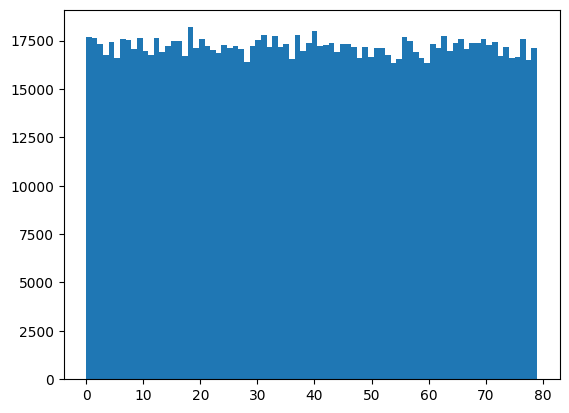

In [ ]:
actions = data['action']
unique_values, counts = np.unique(actions, return_counts=True)
print("Unique values - actions:", unique_values)
print("Counts:", counts)
plt.hist(actions, bins=80)
plt.show()

Actions are shown in roughly equal proportions, but we can look at the most popular and least popular ones too:

In [7]:
unique_actions, action_counts = np.unique(data['action'], return_counts=True)
print(f"Number of unique actions: {len(unique_actions)}")
print(f"Most popular action shown {action_counts.max()} times")
print(f"Least popular action shown {action_counts.min()} times")

Number of unique actions: 80
Most popular action shown 18184 times
Least popular action shown 16325 times


Showwing which actions got rewards, i.e., whether all actions have been clicked:

In [8]:
rewarded_actions = data['action'][data['reward'] == 1]
print(f"Actions that got clicks: {np.unique(rewarded_actions)}")

Actions that got clicks: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79]


Success rate by action (for actions that got clicks):

In [10]:
for action in np.unique(rewarded_actions):
    action_mask = data['action'] == action
    success_rate = data['reward'][action_mask].mean()
    total_shown = action_mask.sum()
    clicks = data['reward'][action_mask].sum()
    print(f"Action {action}: {success_rate:.3f} click rate ({clicks:.0f} clicks out of {total_shown} times shown)")

Action 0: 0.003 click rate (48 clicks out of 17657 times shown)
Action 1: 0.002 click rate (39 clicks out of 17616 times shown)
Action 2: 0.001 click rate (22 clicks out of 17299 times shown)
Action 3: 0.003 click rate (43 clicks out of 16729 times shown)
Action 4: 0.001 click rate (20 clicks out of 17428 times shown)
Action 5: 0.002 click rate (41 clicks out of 16594 times shown)
Action 6: 0.005 click rate (80 clicks out of 17555 times shown)
Action 7: 0.005 click rate (92 clicks out of 17516 times shown)
Action 8: 0.004 click rate (75 clicks out of 17062 times shown)
Action 9: 0.003 click rate (45 clicks out of 17651 times shown)
Action 10: 0.002 click rate (26 clicks out of 16950 times shown)
Action 11: 0.003 click rate (57 clicks out of 16730 times shown)
Action 12: 0.002 click rate (31 clicks out of 17632 times shown)
Action 13: 0.002 click rate (28 clicks out of 16928 times shown)
Action 14: 0.002 click rate (30 clicks out of 17239 times shown)
Action 15: 0.002 click rate (37 cli

### Context

##### **Per-Feature Activation Rate**

How often each context feature is “on” (i.e., equals 1):

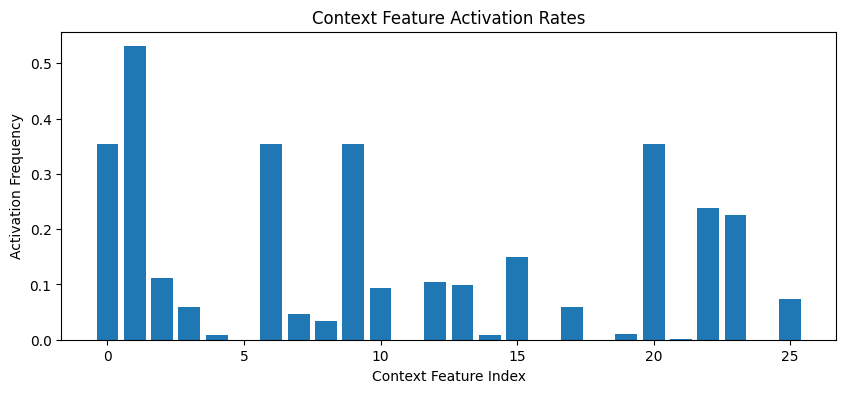

In [11]:
context_matrix = data["context"]
activation_rate = context_matrix.mean(axis=0)

plt.figure(figsize=(10,4))
plt.bar(range(len(activation_rate)), activation_rate)
plt.xlabel("Context Feature Index")
plt.ylabel("Activation Frequency")
plt.title("Context Feature Activation Rates")
plt.show()

This shows the average activation rate for each binary context feature. The plot reveals that while some features are frequently active (e.g., feature 1 appears in over 50% of samples), others are almost never activated. 

This sparsity implies that certain features provide little to no information during training, making it difficult for any learning algorithm to associate them with specific actions or rewards. These rarely active features could potentially be dropped or regularized more heavily in models to reduce noise and improve learning efficiency - which we will.

##### **Sparsity Per Row**

How many features are “on” for each user (row):

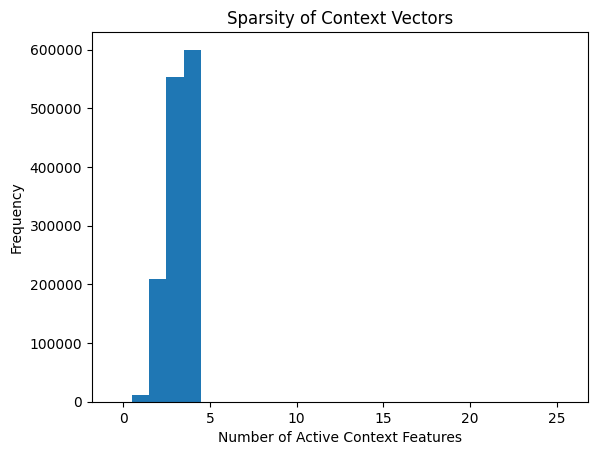

In [12]:
sparsity = context_matrix.sum(axis=1)

plt.hist(sparsity, bins=range(0, context_matrix.shape[1] + 1), align='left')
plt.xlabel("Number of Active Context Features")
plt.ylabel("Frequency")
plt.title("Sparsity of Context Vectors")
plt.show()

This histogram shows the number of active (i.e., non-zero) context features per user interaction. We observe that almost all context vectors have only **2 to 4 features active**, despite having 26 dimensions in total.

This confirms that the dataset is highly sparse, which is typical for one-hot or multi-hot encoded categorical features. From a modeling perspective, it means that:
- Only a small subset of features is relevant per interaction
- Models must learn efficiently from these sparse signals
- Regularization or dimensionality reduction may help if certain features carry little information

##### **Co-Occurrence**

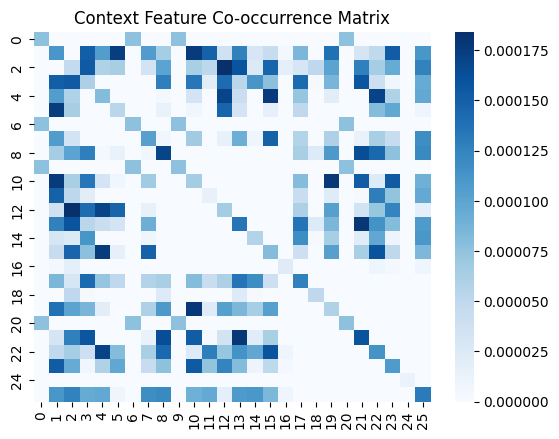

In [ ]:
co_matrix = (context_matrix.T @ context_matrix) / context_matrix.shape[0]
sns.heatmap(co_matrix, cmap="Blues")
plt.title("Context Feature Co-occurrence Matrix")
plt.show()

##### **PCA**

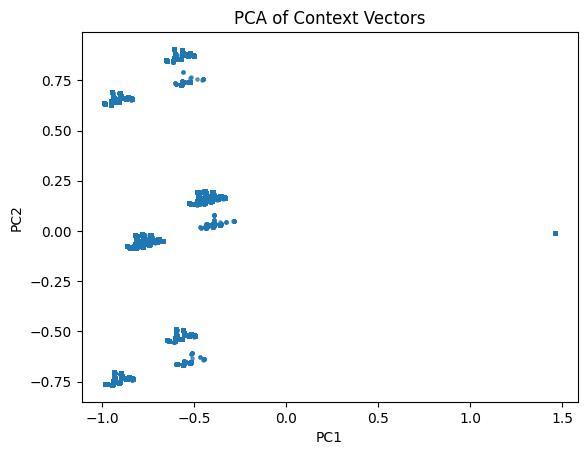

In [ ]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(context_matrix)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.3, s=5)
plt.title("PCA of Context Vectors")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### Context Feature Preprocessing

The co-occurrence matrix and PCA projection suggest that the context space is highly sparse and low-dimensional. Many context features are rarely active and do not contribute meaningfully to the variance in the data. 

To improve learning and reduce computational overhead, we propose the following preprocessing steps:
- **Drop rarely active features** (e.g., activated in <1% of samples)
- **Apply PCA** to reduce the dimensionality of the context vectors (still exaplaining 99% of the data though)
- **Normalize inputs** if any continuous context features are included in the future

This should improve model robustness and accelerate convergence in downstream learning.